In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [45]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy import desc
import datetime




In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [18]:
# reflect an existing database into a new model
metadata = sqlalchemy.MetaData()
# reflect the tables
metadata.reflect(bind=engine)

In [19]:
# calling from sqlalchemy
base = automap_base()

# preparing the reflection of the tables based on the engine
base.prepare(engine, reflect = True)

# view all of the classes that automap found
print("All classes found via automap:")
for table_name in base.classes.keys():
    print(table_name)

All classes found via automap:
measurement
station


In [21]:
# Create our session (link) from Python to the DB

measurement = base.classes.measurement

station = base.classes.station

Session = sessionmaker(bind=engine)

session = Session()

measurement_results = session.query(measurement).all()

station_results = session.query(station).all()

In [22]:
# saving references in a dictionary
tables = {
    'Measurement': base.classes.measurement,
    'Station': base.classes.station
}

In [23]:
# accessing measurement table via dictionary 
measurement_results = session.query(tables['Measurement']).all()

# accessing station table via dictionary
station_results = session.query(tables['Station']).all()

# Exploratory Precipitation Analysis

In [24]:
# find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# find date from results 
if most_recent_date:
    most_recent_date = most_recent_date[0]

# print most recent date
print("The most recent date is:", most_recent_date)

The most recent date is: 2017-08-23


In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

most_recent_date = datetime.datetime.strptime(most_recent_date, '%Y-%m-%d').date()

one_year_ago = most_recent_date - datetime.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

results = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago)\
    .order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=["Date", "Precipitation"])

# Sort the dataframe by date

df = df.sort_values("Date")

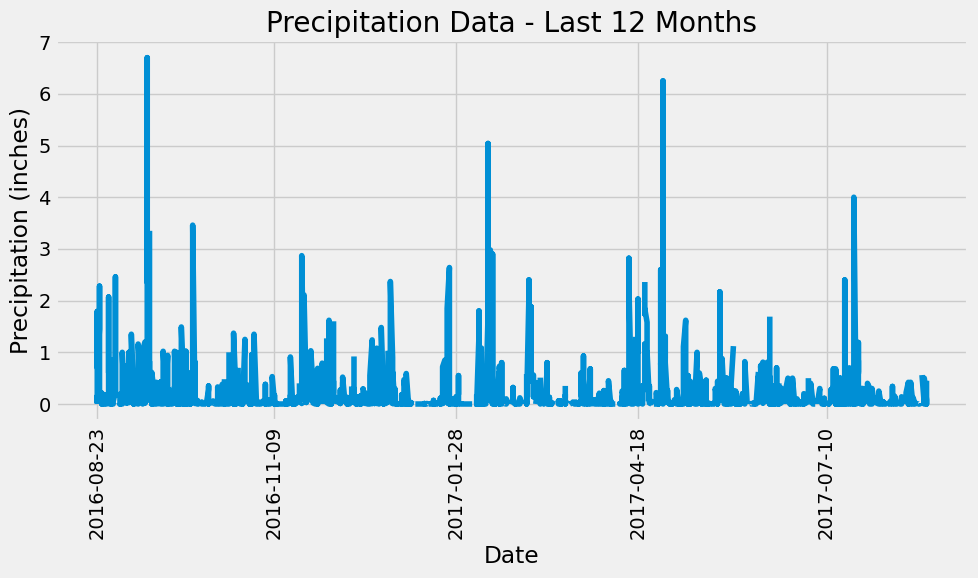

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data - Last 12 Months')

# Set the x-axis ticks to display specific dates
plt.xticks(['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10'], rotation=90)

plt.tight_layout()
plt.show()


In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(station.station)).scalar()

# Print the result
print("Total number of stations: ", total_stations)


Total number of stations:  9


In [46]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(desc(func.count(measurement.station))).all()

# Print the result
print("Most Active Stations:")
for station, count in active_stations:
    print("Station:", station, "Count:", count)

Most Active Stations:
Station: USC00519281 Count: 2772
Station: USC00519397 Count: 2724
Station: USC00513117 Count: 2709
Station: USC00519523 Count: 2669
Station: USC00516128 Count: 2612
Station: USC00514830 Count: 2202
Station: USC00511918 Count: 1979
Station: USC00517948 Count: 1372
Station: USC00518838 Count: 511


In [47]:
# Retrieve the most active station id
most_active_station = active_stations[0][0]

# Perform a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    filter(measurement.station == most_active_station).all()

# Print the result
print("Temperature Statistics for the Most Active Station (Station ID:", most_active_station, "):")
print("Lowest Temperature:", temperature_stats[0][0])
print("Highest Temperature:", temperature_stats[0][1])
print("Average Temperature:", temperature_stats[0][2])

Temperature Statistics for the Most Active Station (Station ID: USC00519281 ):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


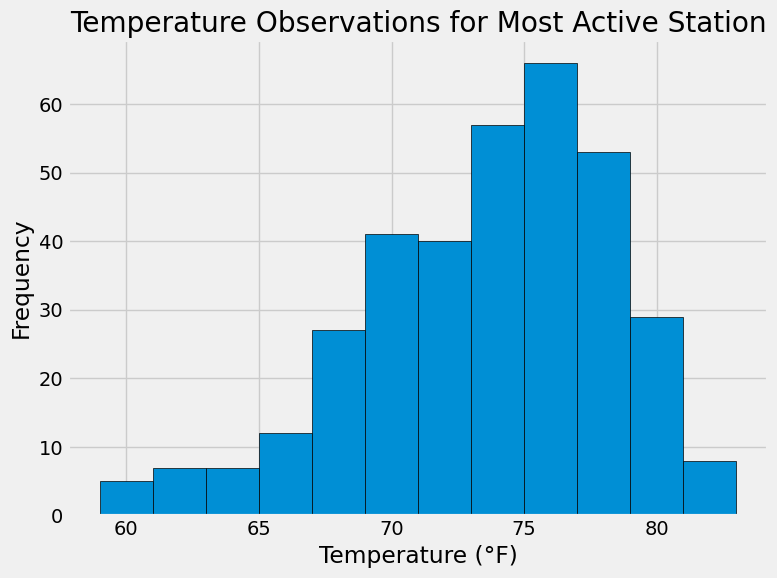

In [48]:
# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.tobs).\
                    filter(measurement.station == most_active_station).\
                    filter(measurement.date >= one_year_ago).all()

# Convert the query results to a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station')
plt.tight_layout()
plt.show()

# Close Session

In [49]:
# Close Session
session.close()